## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [3]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    y = np.array(y, dtype=np.float64)
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header = 1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header = 1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_26, ignore_index=True)

normalize_dataset_labels(initial_dataset)

## Criando modelo da rede neural

In [4]:
class Net:
    def build(self, shape = (41,), classes = 141):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        self.built = model
        return model
    
    def compile(self, learning_rate = 0.01, comms_round = 100):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                          optimizer = 'adam',
                        metrics = ['accuracy'])

## Criando modelo do servidor

In [5]:
class Server:
    def __init__(self, dataset = list(), model = Net(), learning_rate = 0.01, comms_round = 100, num_clients = 5):
        self.num_clients = num_clients
        self.dataset = dataset
        X = self.dataset.iloc[:, 5:-1].values
        y = self.dataset.iloc[:, -1].values
        
        self.dataset.iloc[:, 5:-1] = X
        self.dataset.iloc[:, -1] = y
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        self.num_labels = len(set(y))
        self.input_shape = X.shape[1:]
        self.global_model = model
        self.global_model.build(classes = self.num_labels, shape = self.input_shape)
        
        self.learning_rate = learning_rate
        self.comms_round = comms_round
        self.global_model.compile(self.learning_rate, self.comms_round)
    
    def split_dataset_non_iid(self, clients):
        unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
        client_index, i = (0,0)
        while client_index < num_clients:
            local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[i]]
            value_counts = local_dataset['class'].value_counts()
            num_classes = len(value_counts)
            if num_classes > 1:
                print(value_counts)
                clients[client_index].local_dataset = local_dataset
                clients[client_index].num_labels = self.num_labels
                clients[client_index].input_shape = self.input_shape
                client_index += 1
            i += 1
            
        
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            # Scaling each model weight for each client model with dataset size mean
            for i in range(len(local_weights)):
                scaled_weight = local_weights[i] * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        # agragate local models weights to global model
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)

## Criando modelo do cliente

In [6]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0], model = Net(), num_labels = 141):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
        
    def apply_mixed_oversample(self, X, y):
        value_counts = self.local_dataset.iloc[:, -1].value_counts()
        smote_classes, random_classes, k = ({}, {}, sys.maxsize)
        max_count = max(value_counts.values)

        for key, value in value_counts.items():
            if value > 5:
                smote_classes[key] = max_count
                if k > value:
                    k = value - 1
            else:
                random_classes[key] = max_count

        smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
        random_oversample = RandomOverSampler(sampling_strategy = random_classes)
        X, y = smote_oversample.fit_resample(X, y)
        return random_oversample.fit_resample(X, y)
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
         
#         sc = StandardScaler()
#         X = sc.fit_transform(X)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
       
        
    def train_model(self):
        self.batch_size = 128
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = self.batch_size, 
                                   epochs=1, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        
        prec = precision_score(self.y_test, y_pred, average = 'micro')
        
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test)
        
        self.metrics_history.append((loss, acc, prec))
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 
        
    def plot_result(self, rounds):
        loss_history, acc_history, prec_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy score')
        plt.legend()
        plt.show()
        
        plt.plot(epochs, prec_history, 'r', label='Precision')
        plt.title(f'Precision history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [7]:
num_clients = 10
learning_rate = 0.01
train_rounds = 10
server = Server(initial_dataset, learning_rate = learning_rate, comms_round = train_rounds, num_clients = num_clients)
clients = [Client(client_id = i) for i in range(num_clients)]

server.split_dataset_non_iid(clients)

0.0    287944
1.0     37869
6.0        86
2.0        15
4.0         2
3.0         1
Name: class, dtype: int64
0.0    221592
1.0     90160
6.0        58
Name: class, dtype: int64
0.0    201866
1.0        58
Name: class, dtype: int64
1.0    90864
0.0    65471
6.0       60
Name: class, dtype: int64
0.0    88587
1.0     6793
6.0        2
Name: class, dtype: int64
0.0    69581
1.0     8579
6.0       22
Name: class, dtype: int64
1.0    36859
0.0    36007
6.0       31
2.0        4
Name: class, dtype: int64
0.0    45865
1.0    24756
Name: class, dtype: int64
0.0    64374
1.0       15
Name: class, dtype: int64
0.0    62041
1.0      506
Name: class, dtype: int64


## Treinando e testando modelos NN locais

In [8]:
for i in range(train_rounds):
    local_clients_train = list()
    # atualiza os pesos dos modelos locais antes do treinamento
    server.send_global_model_weights(clients)

    for client in clients:
        client.preprocess()
        client.train_model()
        
        # envia pesos do modelo local e tamanho do dataset local de cada cliente pro servidor
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)
    
print(f"[INFO] All local trains are finished!")


[INFO] Local test of client 0
2037/2037 [==============================] - 1s 371us/step - loss: 4.7442 - accuracy: 0.8827
[[57081   465     0     0]
 [ 7160   456     0     0]
 [    5     0     0     0]
 [   17     0     0     0]]

[INFO] Local test of client 1
1949/1949 [==============================] - 1s 414us/step - loss: 3.2178 - accuracy: 0.7113
[[43849   521     0]
 [17478   506     0]
 [    8     0     0]]

[INFO] Local test of client 2
1263/1263 [==============================] - 1s 969us/step - loss: 0.0859 - accuracy: 0.9996
[[40370     0]
 [   15     0]]

[INFO] Local test of client 3
978/978 [==============================] - 1s 533us/step - loss: 0.8710 - accuracy: 0.8246
[[ 8140  4890     0]
 [  581 17653     0]
 [   15     0     0]]

[INFO] Local test of client 4
597/597 [==============================] - 0s 370us/step - loss: 0.1242 - accuracy: 0.9477
[[17072   690]
 [  308  1007]]

[INFO] Local test of client 5
489/489 [==============================] - 0s 336us/st

## Plotando resultados dos treinos locais

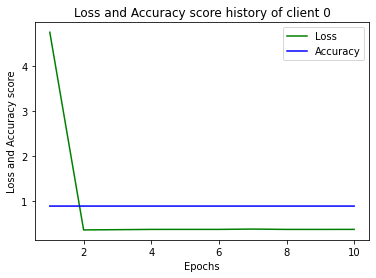

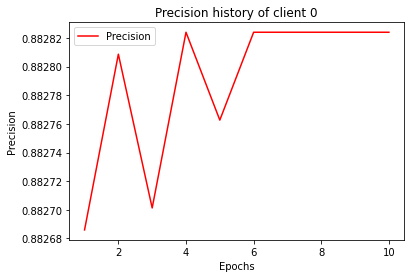

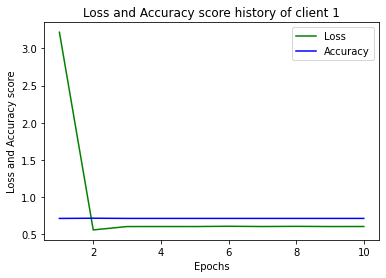

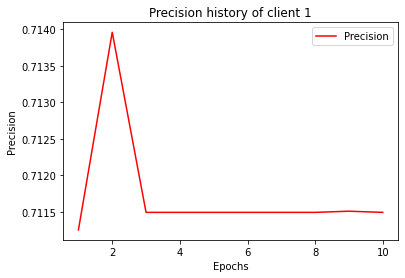

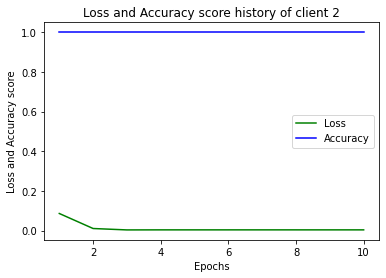

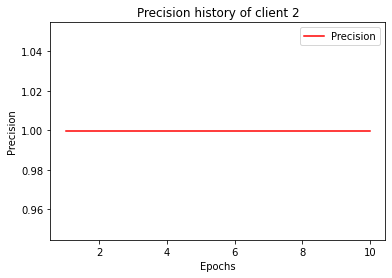

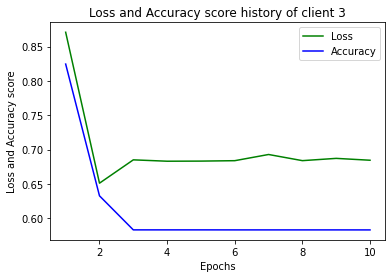

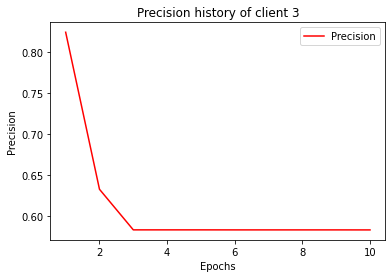

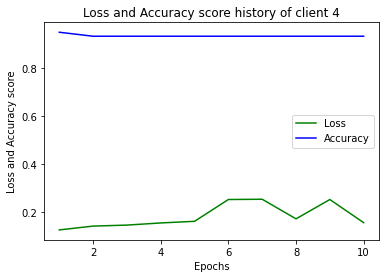

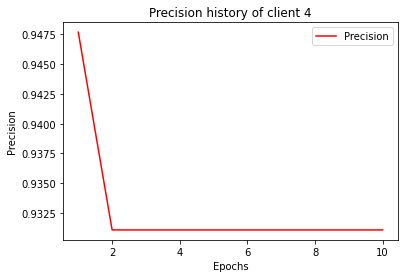

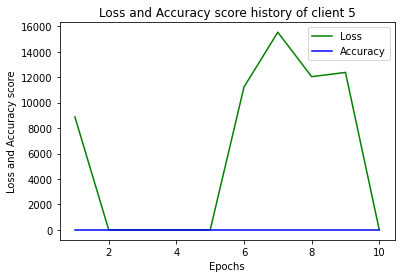

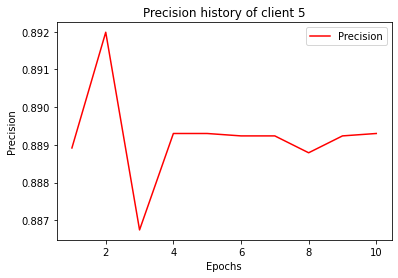

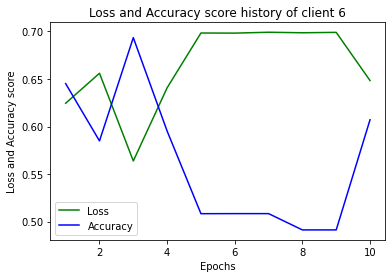

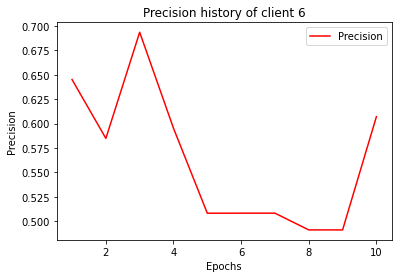

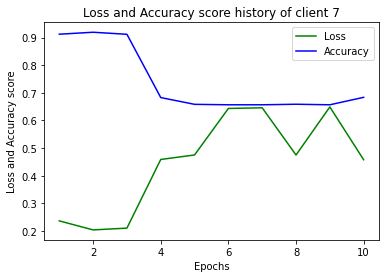

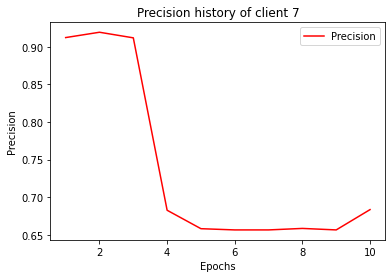

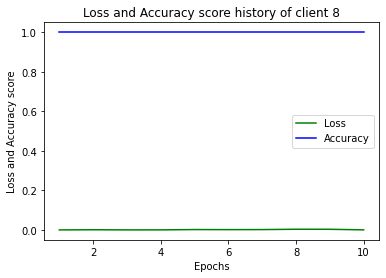

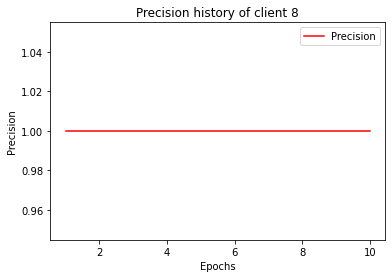

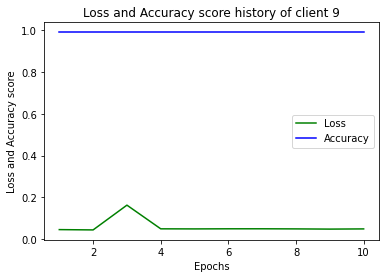

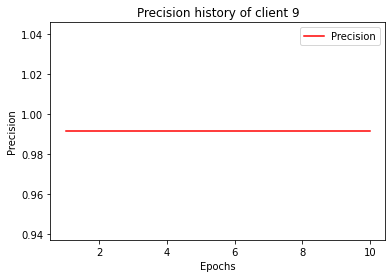

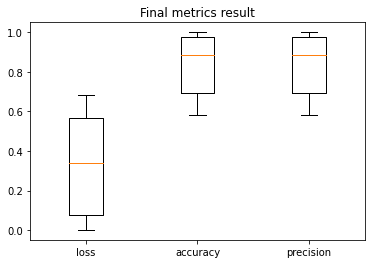

In [9]:
final_metrics = [[],[],[]]
for client in clients:
    client.plot_result(train_rounds)
    for i in range(3):
        final_metrics[i].append(client.metrics_history[-1][i])

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1,2,3], ['loss', 'accuracy', 'precision'])
plt.show()